In [6]:
from pyrosm import OSM
from pyrosm import get_data
import openeo
import matplotlib.pyplot as plt

import os

In [9]:
city = "Berlin"

USE_LOCAL = False

In [8]:

if not os.path.exists(os.path.join('data', city)):
    USE_LOCAL= False
if not USE_LOCAL:
    os.makedirs(os.path.join('data', city))

FileExistsError: [Errno 17] File exists: 'data/Berlin'

In [4]:
# Download data for given city, or load if already downloaded
fp = get_data(city, directory=os.path.join('data', city))
osm = OSM(fp)
print("Loaded OSM data for " + city)

# Filter buildings
buildings = osm.get_buildings()
print("Filtered buildings in " + city)

# Get boundaries of the city
min_x, min_y, max_x, max_y = buildings.total_bounds
print("Coordinates of " + city + ": " +  str(min_x), str(min_y), str(max_x), str(max_y))

Loaded OSM data for Berlin
Filtered buildings in Berlin
Coordinates of Berlin: 12.760000228881836 52.22999954223633 13.979997634887695 52.81999969482422


In [30]:
if not USE_LOCAL:

    # create connection
    connection = openeo.connect("https://openeo.cloud")

    # authenticate
    connection.authenticate_oidc()

    # define time
    temporal_extent = ["2024-04-01", "2024-05-21"]

    # define coordinates
    bbox ={"west": min_x, "south": min_y, "east": max_x, "north": max_y}

    # define the collection ID 
    collection_id = "SENTINEL2_L2A"

    # define bands
    bands=["B04", "B03", "B02", ]

    # load the data collection
    datacube = connection.load_collection(
        collection_id=collection_id,
        spatial_extent=bbox,
        temporal_extent=temporal_extent,
        bands=bands, 
        max_cloud_cover = 1
    )

    # TODO deal with no data found in timeinterval because of small cloud cover threshold of 1.

    # download and safe data
    datacube.download(os.path.join("data", city, "sat_images.nc") )



Authenticated using refresh token.


/home/benni/.venvs/AML/lib/python3.12/site-packages/openeo/rest/connection.py:1207: UserWarning:

SENTINEL2_L2A property filtering with properties that are undefined in the collection metadata (summaries): eo:cloud_cover.



In [10]:
import plotly.express as px
import numpy as np
import xarray as xr

# view satelite image


# load dataset
ds = xr.load_dataset(os.path.join("data", city, "sat_images.nc"))

# plot with plt
# ds.drop_vars("crs").mean(dim="t").to_array(dim="bands").plot.imshow(vmin=0, vmax=2000)

# plot mean of found images
data = ds.drop_vars("crs").mean(dim="t").to_array(dim="bands")

# plot last image downloaded
# data = ds.drop_vars("crs").to_array(dim="bands")[{"t": -1}]

### create array to be plotted by plotly ###

# change axis order
arr = np.moveaxis(np.array(data), [0], [2])

# define threshold, everything above will be set to this threshold,

#this threshold produced nice looking images, found through trial and error
threshold= 3000

# replacce pixels over threshold with threshold values
arr[arr>threshold] = threshold

# create figure
fig = px.imshow(arr/threshold, )

# adjust figure size
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)

In [ ]:
# install rasterio
#!pip install plotly nbformat h5netcdf netcdf4


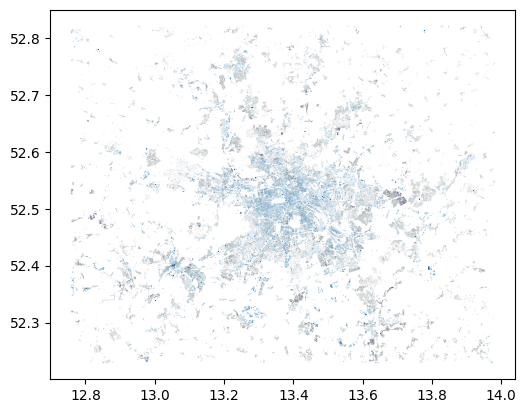

In [16]:
# Plotting the data

# TODO single band
fig, ax = plt.subplots(1, 1)

plot = buildings.plot(ax=ax)
# TODO: plot RGB
# TODO: plot ZRB
# TODO: plot overlapping building